# Наумкин Владимир, С01-119.

## Задача 2. Классификация даты документа.

### Подключим библиотеки

In [1]:
import artm

Отдельный комментарий про artm для винды:

1 Скачиваем архив https://github.com/bigartm/bigartm/releases/download/v0.9.0/BigARTM_v0.9.0_win64.7z.

2 Распакуем архив в папку bigartm, запускаем jupyter с помощью bat скрипта (обязательно выходим из cmd после выполнения, если запускаем не двойным кликом, т.к. set работает в текущей консоли и при перезапуске задублирует ещё раз из-за %, кстати, после % по идее надо бы добавить знак ; но у меня и так он ставится автоматически, можно проверить ячейкой !path):

set PATH=%PATH%C:\full\path\to\bigartm\bin

set PYTHONPATH=%PYTHONPATH%C:\full\path\to\bigartm\python

set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

jupyter notebook

3 В функции fit online (вроде так называлась, надо сделать в двух файлах) переименовываем параметр async на assync.

4 Также в комментариях убираем плохие символы.

5 Пункты 3 и 4 очевидны по ошибкам при попытке import artm.

6 Радуемся, что вроде смогли исправить исходники и всё же подключить либу.

7 ??? Profit!))

8 Всё равно artm.dll из bigartm\bin не видно (например, в ячейке при создании vocab), причём ищет по пути bigartm\python\artm (с заходом во wrapper и ..). Ну что же, тупо скопируем dll в это место.

In [2]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### Уберём предупреждения

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Датасет
Скачаем предобработанные данные (формы слов нормализованы) по ссылке https://disk.yandex.ru/d/bwUVH8hR1MRNrg.

In [4]:
df = pd.read_csv('lenta-ru-proccess.csv')
df

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


Перевод в формат для bigartm

In [5]:
f_valid = ('valid.vw.txt')
f_train = ('train.vw.txt')

In [7]:
if True: # если надо сделать новые txt из csv
    train_count = 0
    valid_count = 0
    train_labels = []
    valid_labels = []
    non_word_char_removal = re.compile(r'\W+')
    with open(f_valid, 'w', encoding='utf-8') as validation_file, open(f_train, 'w', encoding='utf-8') as training_file:
        for index in tqdm(range(len(df))):
            processed_text = non_word_char_removal.sub(' ', df.loc[index, 'text']).strip().split()
            month = df.loc[index, 'date'].split('-')[1]
            year = df.loc[index, 'date'].split('-')[2]
            tag = df.loc[index, 'tags']
            if pd.isna(tag):
                tag = 'unknown'  # замена NaN тега
            else:
                tag = tag.lower().strip()
            if len(processed_text) > 100:
                if (index + 1) % 100 == 0:
                    validation_file.write(f'doc_{valid_count} {" ".join(processed_text)} |@tag class_{tag} |@month class_{month}\n')
                    valid_count += 1
                    valid_labels.append(year)
                else:
                    training_file.write(f'doc_{train_count} {" ".join(processed_text)} |@tag class_{tag} |@month class_{month} |@year class_{year}\n')
                    train_count += 1
                    train_labels.append(year)
    with open('validation_labels.vw.txt', 'w', encoding='utf-8') as file:
        file.write('\n'.join(valid_labels))
    with open('training_labels.vw.txt', 'w', encoding='utf-8') as file:
        file.write('\n'.join(train_labels))
else: # если уже сделали этот этап ранее
    with open('validation_labels.vw.txt', 'r', encoding='utf-8') as file:
        valid_labels = file.read().split('\n')
    with open('training_labels.vw.txt', 'r', encoding='utf-8') as file:
        train_labels = file.read().split('\n')

  0%|          | 0/863285 [00:00<?, ?it/s]

Создаём батчи

In [9]:
if True:
    batch_vectorizer_train = artm.BatchVectorizer(
        data_path=f_train, data_format='vowpal_wabbit', batch_size=10000, 
        target_folder='training_batches')
    batch_vectorizer_validation = artm.BatchVectorizer(
        data_path=f_valid, data_format='vowpal_wabbit', batch_size=10000, 
        target_folder='validation_batches')
else:
    batch_vectorizer_train = artm.BatchVectorizer(data_path='training_batches',
                                                  data_format='batches')
    batch_vectorizer_validation = artm.BatchVectorizer(data_path='validation_batches',
                                                       data_format='batches')

Создаём словарь

In [10]:
vocab = artm.Dictionary()
vocab.gather(data_path='training_batches')
vocab

artm.Dictionary(name=59fdff35-0f78-41ea-8388-9943d0ec1ed2, num_entries=571174)

### Дефолтная модель

In [11]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    iterator = tqdm(range(10))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})
    model.dump_artm_model('model_default')
else:
    model = artm.load_artm_model('model_default')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

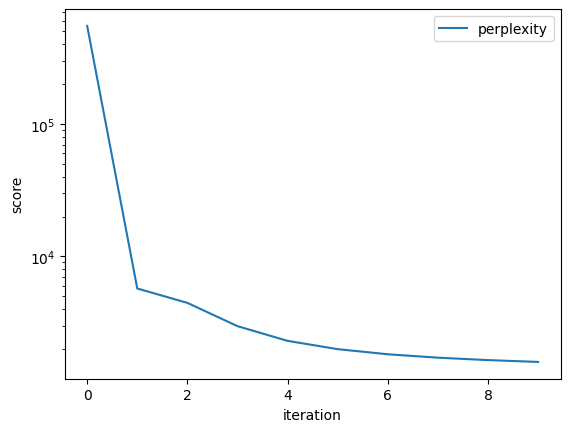

In [12]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

In [13]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'исследователь', 'который', 'это', 'клетка', 'анализ', 'человек', 'результат', 'мочь']
['английский', 'реал', 'барселона', 'англия', 'клуб', 'манчестер', 'челси', 'футболист', 'лондонский', 'испанский']
['германия', 'немецкий', 'который', 'фрг', 'свой', 'еда', 'канцлер', 'меркель', 'ангел', 'кот']
['министерство', 'база', 'конференция', 'зона', 'предложение', 'создание', 'который', 'инициатива', 'ведомство', 'российский']
['документ', 'срок', 'запрет', 'принять', 'правительство', 'введение', 'решение', 'должный', 'год', 'ввести']
['россия', 'российский', 'мид', 'наш', 'это', 'москва', 'заявить', 'рф', 'украина', 'страна']
['министр', 'внутренний', 'анатолий', 'ведомство', 'дело', 'оборона', 'минобороны', 'подпись', 'глава', 'который']
['деятельность', 'государственный', 'контроль', 'журналист', 'служба', 'власть', 'паспорт', 'сми', 'это', 'год']
['директор', 'генеральный', 'аэрофлот', 'год', 'вино', 'культура', 'который', 'новосибирский', 'гендиректор', 'росс

### Классификация

In [14]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [15]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.17      0.05      0.08        19
        2000       0.07      0.03      0.04        69
        2001       0.10      0.05      0.07        96
        2002       0.19      0.14      0.16       143
        2003       0.17      0.15      0.16       134
        2004       0.14      0.12      0.13       183
        2005       0.15      0.16      0.15       240
        2006       0.13      0.12      0.13       256
        2007       0.09      0.06      0.07       236
        2008       0.13      0.16      0.14       332
        2009       0.18      0.23      0.20       423
        2010       0.14      0.16      0.15       375
        2011       0.18      0.20      0.19       384
        2012       0.17      0.19      0.18       427
        2013       0.15      0.13      0.14       387
        2014       0.22      0.16      0.18       309
        2015       0.20      0.20      0.20       387
        2016       0.25    

### Добавление модальностей (обучение новых моделей снова с нуля)

Добавление месяца

In [16]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0,
                             '@month': 1.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    iterator = tqdm(range(10))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1]})
    model.dump_artm_model('model_month')
else:
    model = artm.load_artm_model('model_month')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

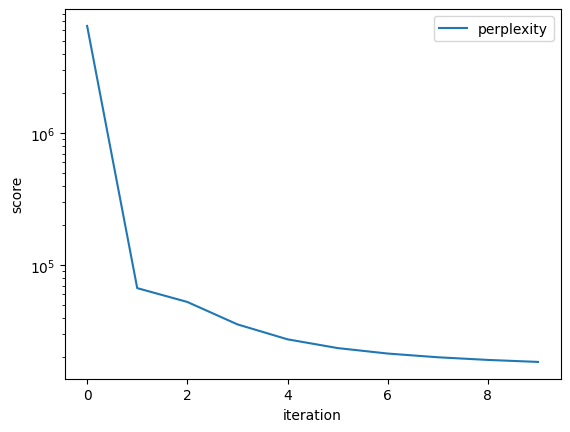

In [17]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

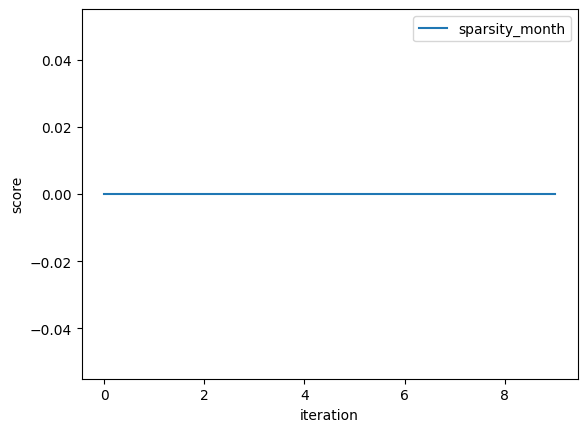

In [18]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [19]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'исследователь', 'который', 'это', 'клетка', 'анализ', 'человек', 'результат', 'мочь']
['английский', 'барселона', 'реал', 'англия', 'клуб', 'манчестер', 'челси', 'испанский', 'футболист', 'лондонский']
['германия', 'который', 'свой', 'фрг', 'еда', 'канцлер', 'меркель', 'немецкий', 'ангел', 'кот']
['министерство', 'база', 'конференция', 'предложение', 'зона', 'создание', 'который', 'инициатива', 'ведомство', 'российский']
['документ', 'срок', 'запрет', 'правительство', 'принять', 'введение', 'ввести', 'решение', 'год', 'должный']
['россия', 'российский', 'мид', 'это', 'наш', 'москва', 'заявить', 'рф', 'украина', 'отношение']
['министр', 'внутренний', 'анатолий', 'ведомство', 'дело', 'оборона', 'минобороны', 'генерал', 'глава', 'который']
['деятельность', 'государственный', 'контроль', 'журналист', 'служба', 'власть', 'паспорт', 'сми', 'это', 'год']
['директор', 'генеральный', 'аэрофлот', 'год', 'вино', 'культура', 'забастовка', 'который', 'новосибирский', 'ро

In [20]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [21]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.25      0.05      0.09        19
        2000       0.17      0.07      0.10        69
        2001       0.12      0.07      0.09        96
        2002       0.17      0.10      0.13       143
        2003       0.16      0.14      0.15       134
        2004       0.15      0.14      0.14       183
        2005       0.13      0.15      0.14       240
        2006       0.11      0.10      0.11       256
        2007       0.09      0.07      0.08       236
        2008       0.15      0.18      0.16       332
        2009       0.16      0.21      0.18       423
        2010       0.17      0.20      0.18       375
        2011       0.16      0.17      0.17       384
        2012       0.19      0.17      0.18       427
        2013       0.13      0.12      0.13       387
        2014       0.22      0.17      0.19       309
        2015       0.23      0.21      0.22       387
        2016       0.25    

Качество, можно сказать, не улучшилось, но при классификации по годам месяц действительно не важен.

Уменьшим вес месяца и введём повышенный вес тега (темы)

In [22]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0,
                             '@month': 0.5,
                             '@tag': 5.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    iterator = tqdm(range(10))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1]})
    model.dump_artm_model('model_month_tag')
else:
    model = artm.load_artm_model('model_month_tag')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

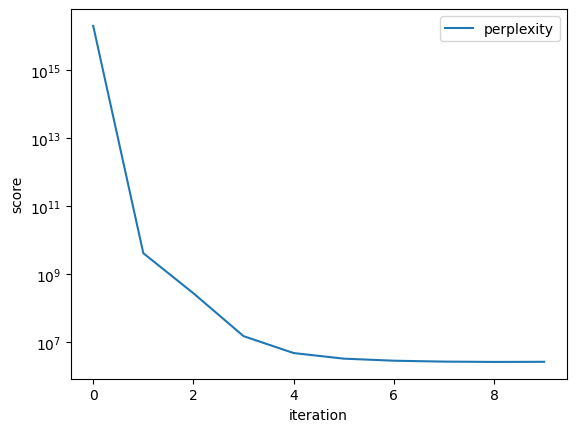

In [23]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

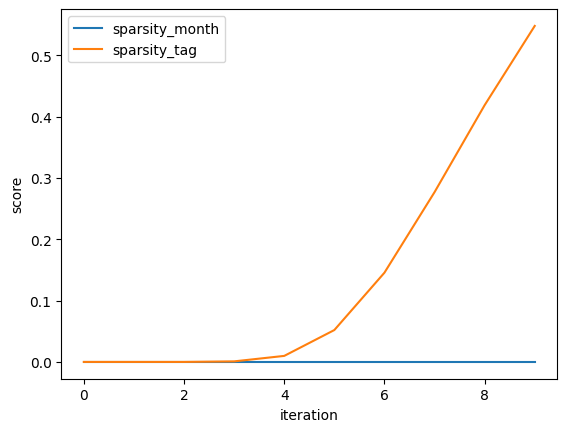

In [24]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [25]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['финансовый', 'алкоголь', 'минфин', 'это', 'год', 'мочь', 'россия', 'облигация', 'пиво', 'напиток']
['клуб', 'год', 'английский', 'контракт', 'перейти', 'испанский', 'переход', 'лондонский', 'манчестер', 'англия']
['ресторан', 'собака', 'питание', 'который', 'еда', 'хозяин', 'кошка', 'кот', 'свой', 'заведение']
['церковь', 'религиозный', 'православный', 'храм', 'академия', 'рана', 'кирилл', 'собор', 'патриарх', 'это']
['документ', 'запрет', 'ввести', 'введение', 'ограничение', 'запретить', 'случай', 'это', 'соответствующий', 'должный']
['южный', 'северный', 'корея', 'мид', 'визит', 'сотрудничество', 'россия', 'кндр', 'рф', 'отношение']
['министр', 'правительство', 'премьер', 'пост', 'отставка', 'глава', 'который', 'новый', 'кабинет', 'премьера']
['турист', 'поездка', 'отель', 'россиянин', 'это', 'отдых', 'туристический', 'курорт', 'путешествие', 'российский']
['директор', 'газета', 'год', 'совет', 'генеральный', 'коммерсант', 'писать', '2006', 'издание', '2008']
['германия', 'немецкий

In [26]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [27]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.12      0.05      0.07        19
        2000       0.17      0.12      0.14        69
        2001       0.07      0.04      0.05        96
        2002       0.12      0.11      0.12       143
        2003       0.13      0.10      0.12       134
        2004       0.18      0.18      0.18       183
        2005       0.15      0.17      0.16       240
        2006       0.12      0.13      0.13       256
        2007       0.13      0.11      0.12       236
        2008       0.14      0.19      0.16       332
        2009       0.23      0.27      0.25       423
        2010       0.16      0.19      0.18       375
        2011       0.19      0.22      0.20       384
        2012       0.21      0.19      0.20       427
        2013       0.35      0.32      0.33       387
        2014       0.25      0.17      0.21       309
        2015       0.24      0.21      0.22       387
        2016       0.28    

Видно, что качество немного улучшилось, но модель лучше бы обучить подольше (см. sparsity_tag). К чему мы и переходим.

### Добавление регуляризаторов к наилучшей предобученной модели

In [28]:
model = artm.load_artm_model('model_month_tag')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

In [29]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth',
                                                      tau=10,
                                                      class_ids=['@default_class']))

In [30]:
iterator = tqdm(range(5))
for i in iterator:
    model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                          'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1]})
model.dump_artm_model('model_month_tag_smooth')

  0%|          | 0/5 [00:00<?, ?it/s]

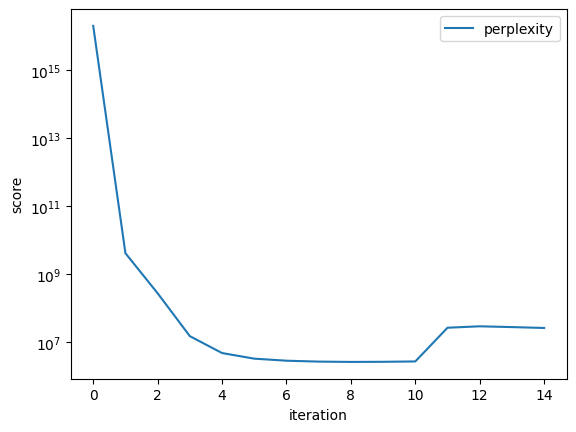

In [31]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

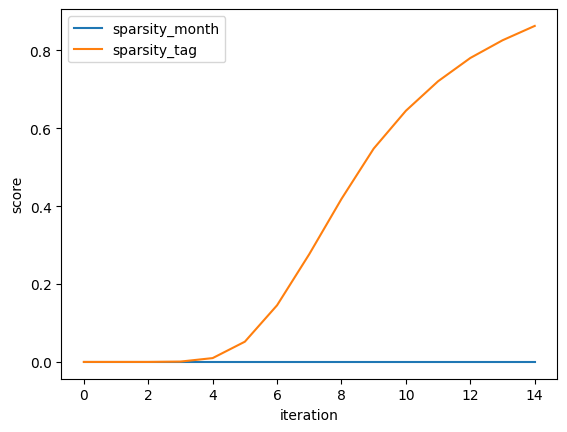

In [32]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [33]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['алкоголь', 'пиво', 'напиток', 'водка', 'алкогольный', 'спирт', 'спиртное', 'егаиса', 'литр', 'бутылка']
['испанский', 'манчестер', 'челси', 'английский', 'англия', 'юнайтед', 'клуб', 'испания', 'лондонский', 'контракт']
['ресторан', 'блюдо', 'макдоналдс', 'питание', 'заведение', 'кот', 'повар', 'меню', 'бургера', 'пицца']
['церковь', 'православный', 'храм', 'собор', 'патриарх', 'рпц', 'священник', 'монастырь', 'патриархат', 'святой']
['документ', 'ввести', 'запрет', 'запретить', 'ограничение', 'введение', 'законопроект', 'разрешить', 'паспорт', 'принятие']
['южный', 'корея', 'северный', 'кндр', 'пхеньян', 'северокорейский', 'южнокорейский', 'корейский', 'сеул', 'ядерный']
['министр', 'правительство', 'пост', 'премьер', 'отставка', 'премьера', 'кабинет', 'должность', 'финансы', 'вица']
['турист', 'туристический', 'путешественник', 'курорт', 'отель', 'отдых', 'туроператор', 'туризм', 'путешествие', 'тур']
['газета', 'директор', 'коммерсант', 'генеральный', 'совет', 'издание', 'косово',

In [34]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [35]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.17      0.13      0.15        69
        2001       0.17      0.12      0.14        96
        2002       0.20      0.15      0.17       143
        2003       0.24      0.21      0.22       134
        2004       0.24      0.22      0.23       183
        2005       0.22      0.26      0.23       240
        2006       0.22      0.20      0.21       256
        2007       0.18      0.14      0.16       236
        2008       0.17      0.21      0.19       332
        2009       0.24      0.34      0.28       423
        2010       0.17      0.18      0.18       375
        2011       0.24      0.25      0.24       384
        2012       0.26      0.28      0.27       427
        2013       0.38      0.42      0.40       387
        2014       0.30      0.20      0.24       309
        2015       0.29      0.25      0.27       387
        2016       0.31    

Как видим, accuracy ещё подросло.

Попробуем другой регуляризатор

In [36]:
model = artm.load_artm_model('model_month_tag')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

In [37]:
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorr',
                                                       tau=10000,
                                                       class_ids=['@tag']))

In [38]:
iterator = tqdm(range(5))
for i in iterator:
    model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                          'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1]})
model.dump_artm_model('model_month_tag_decorr')

  0%|          | 0/5 [00:00<?, ?it/s]

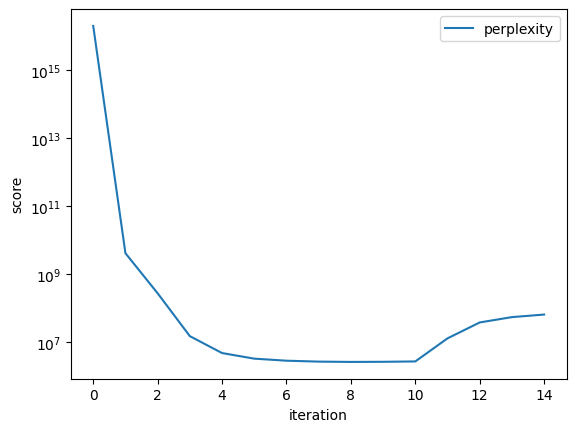

In [39]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

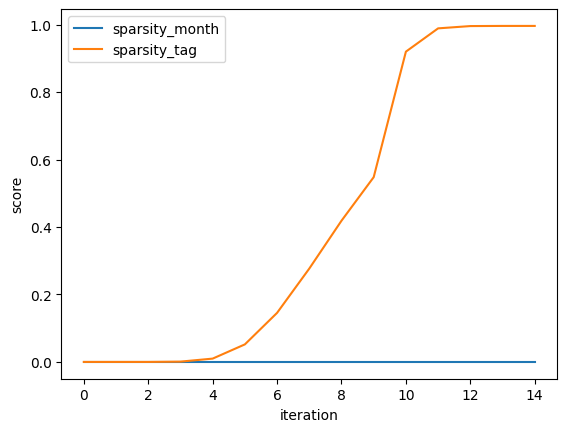

In [40]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [41]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['финансовый', 'алкоголь', 'это', 'минфин', 'внешний', 'мочь', 'облигация', 'напиток', 'пиво', 'россия']
['клуб', 'контракт', 'английский', 'перейти', 'переход', 'испанский', 'сезон', 'год', 'манчестер', 'челси']
['ресторан', 'собака', 'питание', 'еда', 'заведение', 'который', 'хозяин', 'кафе', 'килограмм', 'кот']
['церковь', 'религиозный', 'храм', 'православный', 'рана', 'академия', 'кирилл', 'собор', 'патриарх', 'рпц']
['документ', 'запрет', 'запретить', 'соответствующий', 'ограничение', 'ввести', 'должный', 'случай', 'введение', 'разрешить']
['южный', 'северный', 'корея', 'сотрудничество', 'визит', 'кндр', 'совместный', 'мид', 'иванов', 'делегация']
['министр', 'правительство', 'премьер', 'пост', 'отставка', 'премьера', 'который', 'глава', 'кабинет', 'уйти']
['турист', 'россиянин', 'поездка', 'отель', 'посетить', 'отдых', 'туристический', 'гостиница', 'это', 'праздник']
['газета', 'директор', 'писать', 'совет', '2006', 'генеральный', 'коммерсант', 'год', '2008', 'издание']
['германи

In [42]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [43]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.16      0.13      0.15        69
        2001       0.09      0.07      0.08        96
        2002       0.14      0.10      0.12       143
        2003       0.16      0.13      0.14       134
        2004       0.12      0.12      0.12       183
        2005       0.14      0.18      0.16       240
        2006       0.17      0.21      0.19       256
        2007       0.14      0.13      0.13       236
        2008       0.19      0.24      0.21       332
        2009       0.19      0.23      0.21       423
        2010       0.18      0.19      0.19       375
        2011       0.18      0.20      0.19       384
        2012       0.22      0.22      0.22       427
        2013       0.20      0.16      0.18       387
        2014       0.23      0.16      0.19       309
        2015       0.26      0.24      0.25       387
        2016       0.27    

Как будто бы результат даже стал капельку хуже, но всё равно добавим этот регуляризатор в финальную модель ради эксперимента.

### Финальная модель с нуля по лучшим результатам, добавляем также год как модальность

In [44]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0,
                             '@month': 0.5,
                             '@tag': 5.0,
                             '@year': 10.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))
    # 10 эпох без регуляризаторов
    iterator = tqdm(range(10))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    # на 5 эпох добавляем smooth
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth',
                                                           tau=10,
                                                           class_ids=['@default_class', '@year']))
    iterator = tqdm(range(5))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    # на 5 эпох ещё добавляем decorr
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorr',
                                                           tau=10000,
                                                           class_ids=['@tag', '@year']))
    iterator = tqdm(range(5))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    model.dump_artm_model('model_final')
else:
    model = artm.load_artm_model('model_final')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

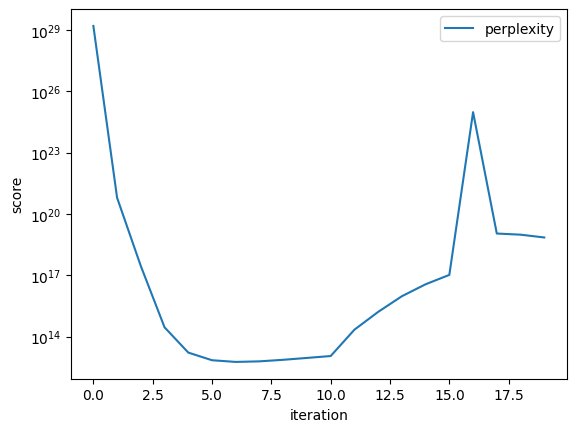

In [45]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

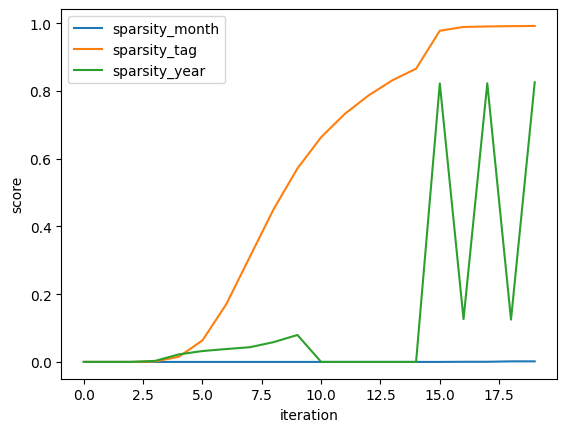

In [46]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [47]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['тоббин', 'тетовый', 'скляров', 'ленск', 'кондит', 'глак', 'штыров', 'гончарик', 'биггз', 'радуев']
['шоумар', 'парпий', 'halfhalftravel', 'цлоо', 'косиков', 'комё', 'тодать', 'дзи', 'азимджон', 'гайрат']
['блюдо', 'плов', 'брюква', 'noma', 'соус', 'диетолог', 'болтунья', 'яичница', 'десерт', 'окрошка']
['церковь', 'православный', 'патриархат', 'патриарх', 'рпц', 'митрополит', 'упц', 'епархия', 'церковный', 'синод']
['байра', 'руаялить', 'бердымухаммед', 'поносов', 'аймас', 'сеголен', 'рудда', 'мастроджакомый', 'telegraf', 'южкузбассуголь']
['фортауна', 'andersen', 'славнефть', 'голдовский', 'биаджи', 'фортаун', 'турмонд', 'enron', 'ntvru', 'пим']
['тоббин', 'тетовый', 'скляров', 'ленск', 'гончарик', 'кондит', 'глак', 'штыров', 'биггз', 'радуев']
['туроператор', 'атор', 'турист', 'ломидзе', 'ростуризм', 'путешественник', 'курорт', 'туриндустрия', 'волченко', 'рст']
['гидроагрегат', 'саять', 'шушенский', 'гэс', 'водосброс', 'гидроэнергоремонт', 'кутьин', 'байра', 'руаялить', 'кярь']
['

In [48]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [49]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       1.00      0.00      0.00        96
        2002       1.00      0.00      0.00       143
        2003       0.06      0.01      0.01       134
        2004       0.16      0.30      0.21       183
        2005       1.00      0.00      0.00       240
        2006       1.00      0.00      0.00       256
        2007       0.08      0.08      0.08       236
        2008       0.09      0.05      0.06       332
        2009       0.14      0.29      0.19       423
        2010       0.13      0.20      0.15       375
        2011       0.17      0.01      0.02       384
        2012       0.12      0.23      0.15       427
        2013       0.17      0.27      0.21       387
        2014       0.02      0.00      0.01       309
        2015       0.16      0.22      0.18       387
        2016       0.19    

По результатам можно сказать, что такая комбинация параметров оказалась неудачной.

Попробуем оставить один регуляризатор и уравнять вклад года и тега.

In [53]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@year': 5.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))
    # 10 эпох без регуляризаторов
    iterator = tqdm(range(10))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    # на 5 эпох добавляем smooth
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth',
                                                           tau=10,
                                                           class_ids=['@default_class', '@year']))
    iterator = tqdm(range(5))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    model.dump_artm_model('model_final_2')
else:
    model = artm.load_artm_model('model_final_2')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

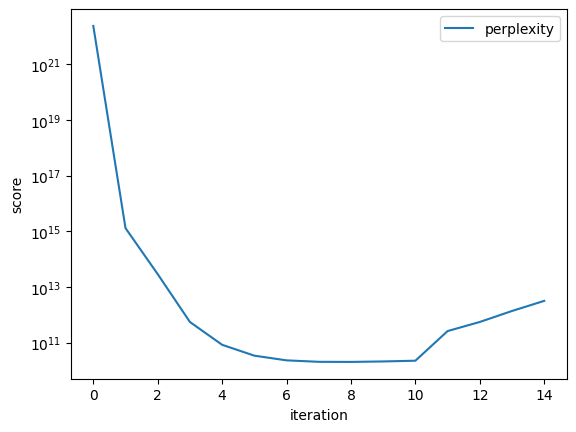

In [54]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

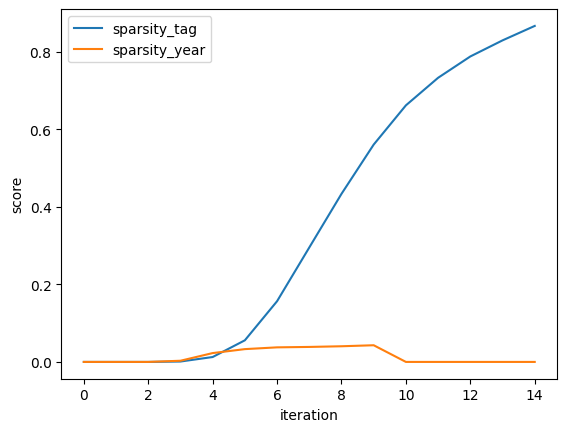

In [55]:
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [56]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['алкоголь', 'пиво', 'напиток', 'водка', 'алкогольный', 'спирт', 'спиртное', 'литр', 'бутылка', 'егаиса']
['англия', 'английский', 'манчестер', 'челси', 'лондонский', 'юнайтед', 'бекхэма', 'клуб', 'абрам', 'мю']
['ресторан', 'блюдо', 'кот', 'питание', 'макдоналдс', 'заведение', 'кошка', 'повар', 'меню', 'еда']
['церковь', 'православный', 'храм', 'собор', 'патриарх', 'священник', 'рпц', 'монастырь', 'религиозный', 'патриархат']
['документ', 'ввести', 'запрет', 'ограничение', 'введение', 'запретить', 'принятие', 'паспорт', 'законопроект', 'правительство']
['мид', 'посольство', 'договор', 'визит', 'дипломат', 'сотрудничество', 'посол', 'иванов', 'иностранный', 'рф']
['реклама', 'рекламный', 'кампания', 'наружный', 'рекламодатель', 'васильев', 'asa', 'outdoor', 'перетяжка', 'рекламировать']
['турист', 'отель', 'туристический', 'путешественник', 'курорт', 'отдых', 'туроператор', 'путешествие', 'туризм', 'гостиница']
['газета', 'писать', '2009', '2008', 'издание', 'директор', 'коммерсант', '

In [57]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [58]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.01      0.05      0.02        19
        2000       0.00      0.00      0.00        69
        2001       0.08      0.04      0.05        96
        2002       0.15      0.01      0.03       143
        2003       0.00      0.00      0.00       134
        2004       0.00      0.00      0.00       183
        2005       0.20      0.01      0.02       240
        2006       0.44      0.03      0.05       256
        2007       0.14      0.00      0.01       236
        2008       0.19      0.09      0.12       332
        2009       0.32      0.09      0.14       423
        2010       0.18      0.03      0.06       375
        2011       0.52      0.04      0.07       384
        2012       0.15      0.31      0.20       427
        2013       0.17      0.22      0.19       387
        2014       0.12      0.33      0.17       309
        2015       0.25      0.14      0.18       387
        2016       0.30    

Такое изменение ни к чему не привело.

Попробуем убрать регуляризацию года и увеличить число эпох без регуляризаторов до 15

In [75]:
if True:
    model = artm.ARTM(num_topics=200,
                  dictionary=vocab, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@year': 5.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))
    # 15 эпох без регуляризаторов
    iterator = tqdm(range(15))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    # на 5 эпох добавляем smooth
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth',
                                                           tau=10,
                                                           class_ids=['@default_class']))
    iterator = tqdm(range(5))
    for i in iterator:
        model.fit_offline(batch_vectorizer_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1]})
    model.dump_artm_model('model_final_3')
else:
    model = artm.load_artm_model('model_final_3')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

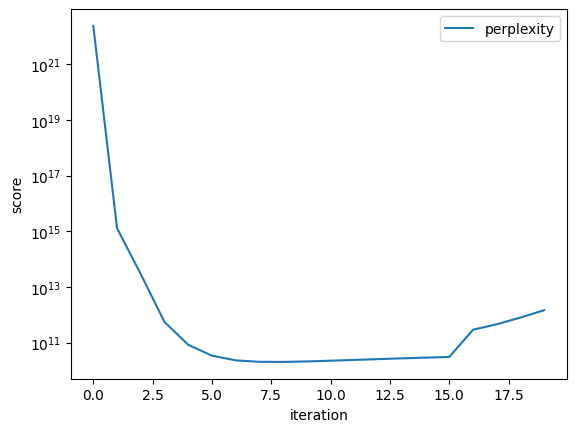

In [76]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

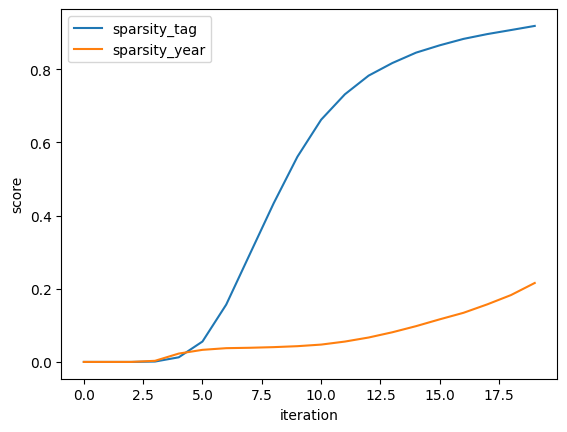

In [77]:
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [78]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['алкоголь', 'напиток', 'пиво', 'алкогольный', 'водка', 'спиртное', 'спирт', 'бутылка', 'литр', 'акциз']
['английский', 'англия', 'манчестер', 'челси', 'лондонский', 'юнайтед', 'клуб', 'арсенал', 'бекхэма', 'ливерпуль']
['собака', 'ресторан', 'кошка', 'кот', 'блюдо', 'питание', 'питомец', 'пёс', 'еда', 'килограмм']
['церковь', 'православный', 'храм', 'религиозный', 'собор', 'священник', 'патриарх', 'рпц', 'монастырь', 'патриархат']
['документ', 'ввести', 'запрет', 'запретить', 'ограничение', 'введение', 'разрешить', 'паспорт', 'гражданин', 'разрешение']
['мид', 'сотрудничество', 'визит', 'рф', 'договор', 'российский', 'иванов', 'иностранный', 'совместный', 'лавров']
['реклама', 'рекламный', 'кампания', 'васильев', 'рекламодатель', 'министерство', 'наружный', 'оборонсервис', 'размещение', 'outdoor']
['турист', 'отель', 'туристический', 'курорт', 'путешественник', 'отдых', 'гостиница', 'туроператор', 'туризм', 'путешествие']
['газета', 'писать', 'издание', '2008', '2009', 'директор', 'ко

In [79]:
X_train_pd = model.transform(batch_vectorizer_train)
X_train = []
for i in tqdm(range(len(train_labels))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(train_labels)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)
X_valid_pd = model.transform(batch_vectorizer_validation)
X_valid = []
for i in tqdm(range(len(valid_labels))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

  0%|          | 0/6604 [00:00<?, ?it/s]

In [80]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train_np, y_train_np)
pred = clf.predict(X_valid)
print(classification_report(valid_labels, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.02      0.05      0.03        19
        2000       0.00      0.00      0.00        69
        2001       0.14      0.03      0.05        96
        2002       0.17      0.08      0.11       143
        2003       0.05      0.02      0.03       134
        2004       0.10      0.01      0.02       183
        2005       0.33      0.02      0.03       240
        2006       0.33      0.00      0.01       256
        2007       0.14      0.02      0.04       236
        2008       0.19      0.05      0.08       332
        2009       0.33      0.07      0.12       423
        2010       0.27      0.01      0.02       375
        2011       0.13      0.63      0.21       384
        2012       0.13      0.12      0.12       427
        2013       0.34      0.19      0.25       387
        2014       0.12      0.23      0.15       309
        2015       0.33      0.09      0.14       387
        2016       0.37    

## Классификация с помощью bigartm

In [99]:
model = artm.load_artm_model('model_final')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

In [100]:
test_probs = model.transform(batch_vectorizer=batch_vectorizer_validation, predict_class_id='@year')
preds = np.argmax(test_probs.to_numpy(), axis=0)
years = test_probs.index.values
y_pred = [years[idx][6:] for idx in preds] # убираем class_ (6 символов)
print(classification_report(valid_labels, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1914       0.00      1.00      0.00         0
        1999       0.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       0.00      0.00      0.00        96
        2002       1.00      0.00      0.00       143
        2003       0.00      0.00      0.00       134
        2004       1.00      0.00      0.00       183
        2005       1.00      0.00      0.00       240
        2006       1.00      0.00      0.00       256
        2007       1.00      0.00      0.00       236
        2008       0.02      0.00      0.01       332
        2009       1.00      0.00      0.00       423
        2010       1.00      0.00      0.00       375
        2011       0.09      0.07      0.08       384
        2012       0.07      0.22      0.11       427
        2013       1.00      0.00      0.00       387
        2014       0.00      0.00      0.00       309
        2015       0.06    

In [101]:
model = artm.load_artm_model('model_final_2')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

In [102]:
test_probs = model.transform(batch_vectorizer=batch_vectorizer_validation, predict_class_id='@year')
preds = np.argmax(test_probs.to_numpy(), axis=0)
years = test_probs.index.values
y_pred = [years[idx][6:] for idx in preds] # убираем class_ (6 символов)
print(classification_report(valid_labels, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       0.00      0.00      0.00        96
        2002       1.00      0.00      0.00       143
        2003       1.00      0.00      0.00       134
        2004       1.00      0.00      0.00       183
        2005       0.00      0.00      0.00       240
        2006       1.00      0.00      0.00       256
        2007       1.00      0.00      0.00       236
        2008       0.10      0.01      0.01       332
        2009       0.18      0.01      0.02       423
        2010       0.08      0.01      0.02       375
        2011       1.00      0.00      0.00       384
        2012       0.09      0.14      0.11       427
        2013       0.04      0.01      0.01       387
        2014       0.06      0.14      0.08       309
        2015       0.09      0.02      0.03       387
        2016       0.14    

In [103]:
model = artm.load_artm_model('model_final_3')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=vocab), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'), overwrite=True)

In [104]:
test_probs = model.transform(batch_vectorizer=batch_vectorizer_validation, predict_class_id='@year')
preds = np.argmax(test_probs.to_numpy(), axis=0)
years = test_probs.index.values
y_pred = [years[idx][6:] for idx in preds] # убираем class_ (6 символов)
print(classification_report(valid_labels, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       0.00      0.00      0.00        96
        2002       1.00      0.00      0.00       143
        2003       1.00      0.00      0.00       134
        2004       1.00      0.00      0.00       183
        2005       0.00      0.00      0.00       240
        2006       1.00      0.00      0.00       256
        2007       0.00      0.00      0.00       236
        2008       0.13      0.02      0.04       332
        2009       0.33      0.01      0.01       423
        2010       0.00      0.00      0.00       375
        2011       0.11      0.37      0.17       384
        2012       0.07      0.06      0.06       427
        2013       0.03      0.00      0.00       387
        2014       0.07      0.11      0.08       309
        2015       0.22      0.01      0.02       387
        2016       0.09    

# Выводы

Классификация с помощью bigartm дала accuracy в 2 раза меньше. Но всё равно это лучше случайного выбора в 2 раза (1/22 = 0.05). Если же использовать внешний классификатор, то наилучший результат дала модель с сильным влиянием модальности темы (тега) без добавления модальности года (а небольшой учёт модальности месяца наверное лучше было бы вообще убрать) и включенным на последние 5 эпох SmoothSparsePhiRegularizer для текстов.